**UNI:** am6490, cj2831, hk3354

**Full name:** Arsh Misra, Conor Jones, Flora Kwon

**Link to Public Github repository with Final report:**
https://github.com/hyerhinkwon/QMSS5074-Adv-ML.git

In [2]:
# Load libraries

import sys
import time
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.applications import ResNet50, InceptionV3

## 0. Loading Dataset

In [5]:
# Import data from desktop

import os
base_path = "/Users/florakwon/Desktop/Spring 2025/QMSS 5074 - Adv ML/Project_2/Project 2/COVID-19_Radiography_Dataset"

## 1. Dataset and Exploratory Data Analysis

*Start by describing the dataset. Include basic statistics and image samples to show the types of images available (e.g., COVID-positive and negative chest x-rays).*

*Check if the dataset is balanced across classes. If it's imbalanced:*
*   *Discuss potential strategies such as class weighting, oversampling, undersampling, or augmentation.*
*   *Indicate which method you chose, and discuss how model performance changed as a result.*

*Reflect on the practical value of this classification task. Who might benefit from your model in a real-world setting?*

In [7]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset' #CONORJ: Added this, double check if it's in the pdf
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# Load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [3616, 10192, 1345]


The original data consists chest X-ray images, 3616 images each for COVID-19 pneumonia, 1345 for viral pneumonia, and 10192 for normal.

To address class imbalance, we can utilize:
1. Class weighting: Assign higher weights to minority classes during training
2. Oversampling: Create synthetic samples of minority classes (e.g., SMOTE)
3. Undersampling: Remove samples from majority classes
4. Data augmentation: Generate additional samples through transformations

For our approach, we decided to artificially balance the dataset (by preserving 1344 samples per class), same as the source paper. This means that all classes will contirubte equally to gradien updates and prevent model bias towards the larger viral pneumonia class and normal cllass. In the paper, this demonstrated improved test accuracy and balanced performance across classes for confusion matrices.

From this classification exercise, we can provide insights to aid healthcare professionals in interpretting radiology reports and provide diagnostic support. From general ML knowledge perspective, it will also improve pattern recognition and its applications.

In [9]:
# Reduce number of images to first 1345 for each category

fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [10]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.

from keras.preprocessing import image
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # Import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # Min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

In [11]:
# Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# Map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [12]:
len(image_filepaths)

4032

In [13]:
print(len(X)) # Same number of elements as filenames
print(X.shape) # Dimensions now 192,192,3 for all images
print(X.min().round()) # Min value of every image is zero
print(X.max()) # Max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [14]:
len(fnames[2])

1344

In [15]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder corresponding to each type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels))

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4027,False,False,True
4028,False,False,True
4029,False,False,True
4030,False,False,True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8425197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.96456695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].


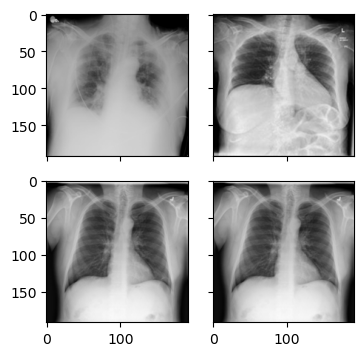

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [18]:
# Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [19]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

## 2. Baseline CNN Model

*Build and train a basic Convolutional Neural Network (CNN) to serve as a baseline.*

*Clearly describe the architecture, loss function, optimizer, evaluation metrics, and
training configuration.*

*Report the model’s training, validation, and test performance.*

In [21]:
# Building baseline CNN

def baseline_cnn(input_shape=(192, 192, 3), num_classes=3):

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(3, activation='softmax')
    ])
    return model

baseline_model = baseline_cnn(input_shape=(192, 192, 3), num_classes=3)
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-21 22:05:22.097316: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-21 22:05:22.097343: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-21 22:05:22.097354: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1745287522.097371 7678761 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745287522.097397 7678761 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB mem

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       884,739 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,635 (3.38 MB)

 Trainable params: 885,635 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

The baseline model is a convolutional neural network built with Keras.

The architecture consists of a single convolutional layer with 32 filters followed by max-pooling to reduce spatial dimensions. The final dense layer with a softmax activation outputs probabilities for 3 classes.

We used Categorical Cross-entropy as the loss function. It is appropriate for multi-class classification problems with one-hot encoded labels, to measure the difference between the true label distribution and the predicted probabilities.

We used Adam as the optimizer, an adaptive learning rate optimizer for deep learning.

We used Accuracy as the evaluation metric, which would indicate proportion of correctly classified samples.

Training is run for up to 5 epochs.  We use the validation set to monitor the performance after each epoch.

In [23]:
baseline_history = baseline_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5


2025-04-21 22:05:23.287479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.4692 - loss: 5.9074 - val_accuracy: 0.8040 - val_loss: 0.5611
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8282 - loss: 0.4311 - val_accuracy: 0.8358 - val_loss: 0.4506
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8615 - loss: 0.3511 - val_accuracy: 0.8730 - val_loss: 0.3437
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9061 - loss: 0.2602 - val_accuracy: 0.8877 - val_loss: 0.3168
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9270 - loss: 0.2132 - val_accuracy: 0.8877 - val_loss: 0.3030


In [24]:
# Code for Training and Validation Performance Plot

def plot_training(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

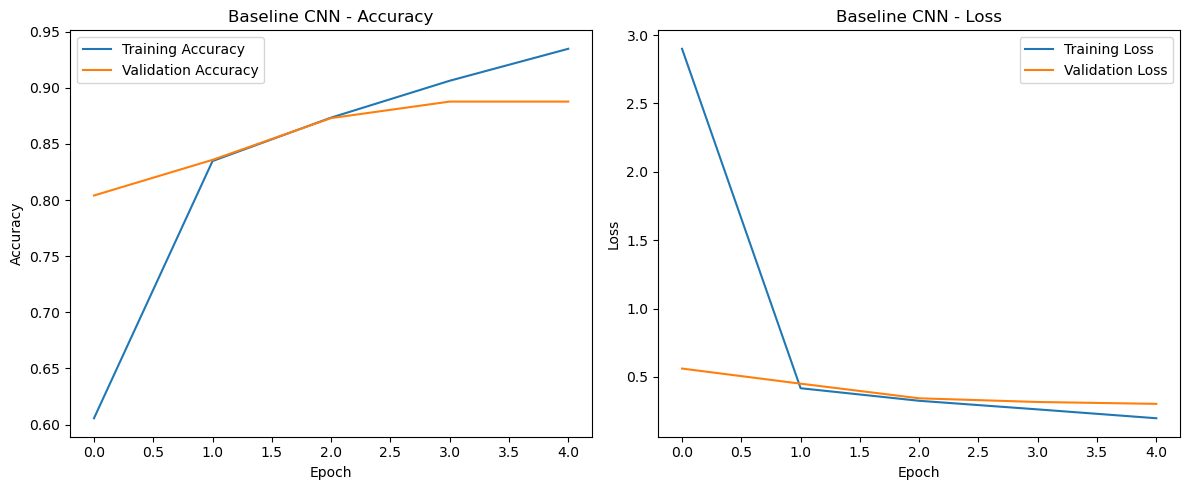

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8757 - loss: 0.3178
Baseline CNN Test Accuracy: 88.77%


In [25]:
# Plot training history
plot_training(baseline_history, 'Baseline CNN')

# Evaluate the model on test data
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test)
print(f"Baseline CNN Test Accuracy: {baseline_test_acc*100:.2f}%")

These results indicate that even though our training accuracy achieves a rate of ~93%, this accuracy doesn't hold on the validation set which drops to ~87.2%. Analyzing the change in validation loss, it seems unlikely that adding more epochs alone would substantially improve the accuracy of this set since the loss has begun to flatline (we see a loss 0f 0.35 in epoch 4 and 0.31 in epoch 5). In fact, we suspect more epochs using this infrastructure may be more likely to lead to overfitting than to improved performance.

The final test accuracy is 89%.

## 3. Transfer Learning with ResNet

*Implement ResNet using transfer learning.*

*Fine-tune the model and compare its performance with the baseline CNN.*

*Discuss how using pre-trained features influences your model's training and generalization.*

In [28]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Create a tf.data pipeline that resizes images on the fly.
def preprocess_and_resize(image, label):
    # Resize image to 224x224 and cast to float32
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image * 255.0, tf.float32)
    # Apply the ResNet50 preprocessing function
    image = resnet_preprocess(image)
    return image, label

# Create tf.data datasets for train and test sets.
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [29]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

# Load ResNet50 model
input_tensor = Input(shape=(224, 224, 3))
base_resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)

# Freeze layers
for layer in base_resnet.layers:
    layer.trainable = False

# Build model with transfer learning
resnet_model = Model(inputs=base_resnet.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
# Fit the ResNet model to our training and validation data sets
history_resnet = resnet_model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10


/opt/anaconda3/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 662ms/step - accuracy: 0.5900 - loss: 0.8971 - val_accuracy: 0.8675 - val_loss: 0.3210
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 639ms/step - accuracy: 0.8782 - loss: 0.3026 - val_accuracy: 0.9070 - val_loss: 0.2483
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 671ms/step - accuracy: 0.9108 - loss: 0.2387 - val_accuracy: 0.9225 - val_loss: 0.2178
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 694ms/step - accuracy: 0.9288 - loss: 0.2041 - val_accuracy: 0.9349 - val_loss: 0.1985
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 744ms/step - accuracy: 0.9393 - loss: 0.1809 - val_accuracy: 0.9411 - val_loss: 0.1846
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 854ms/step - accuracy: 0.9503 - loss: 0.1638 - val_accuracy: 0.9419 - val_loss: 0.1739
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 855ms/step - accuracy: 0.9534 - loss: 0.1503 - val_accuracy: 0.9435 - val_loss: 0.1652
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 799ms/step - accuracy: 0.9560 - loss: 0.1392 - val_accuracy: 0.945

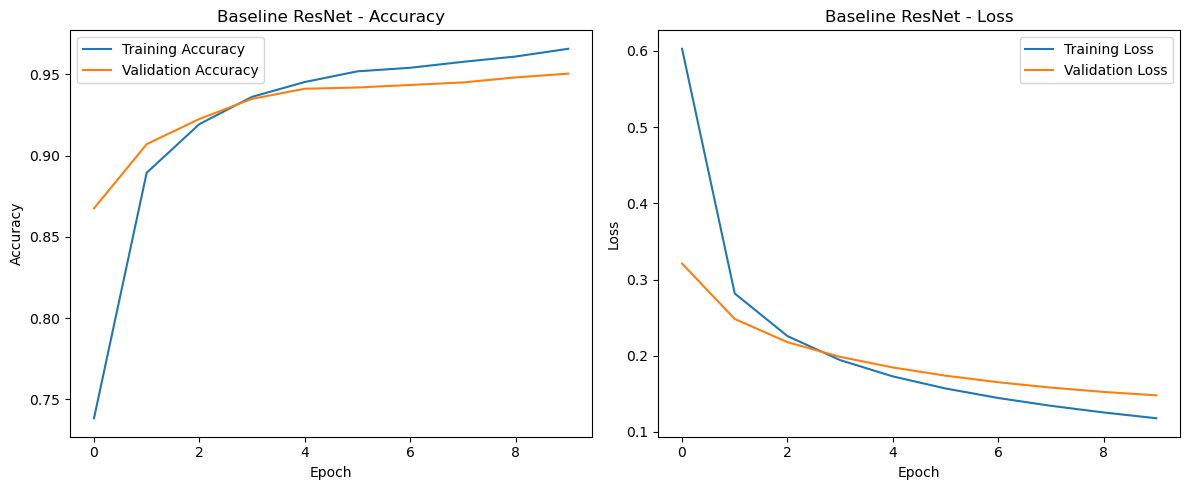

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 593ms/step - accuracy: 0.9527 - loss: 0.1351
Baseline ResNet Test Accuracy: 95.04%


In [31]:
# Plot training history
plot_training(history_resnet, 'Baseline ResNet')

# Evaluate the model on test data
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_ds)
print(f"Baseline ResNet Test Accuracy: {resnet_test_acc*100:.2f}%")

The baseline ResNet model achieves a training accuracy of ~96% over the course of 10 epochs. Furthermore, it's performance on the validation set is ~95% which is a much lower drop from our baseline CNN. The final test accuracy is 95%.

Next we're going to try fine-tuning the model on the training data set over the course of 5 epochs.

In [33]:
# Unfreeze to fine-tune last 30 layers
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

# Re-compile with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history_finetune = resnet_model.fit(train_ds, epochs=15, initial_epoch=10, validation_data=test_ds)

Epoch 11/15


/opt/anaconda3/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6962 - loss: 0.8197 - val_accuracy: 0.8358 - val_loss: 0.5845
Epoch 12/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9761 - loss: 0.0884 - val_accuracy: 0.9047 - val_loss: 0.2828
Epoch 13/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9934 - loss: 0.0446 - val_accuracy: 0.9295 - val_loss: 0.2008
Epoch 14/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9958 - loss: 0.0287 - val_accuracy: 0.9497 - val_loss: 0.1580
Epoch 15/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9981 - loss: 0.0199 - val_accuracy: 0.9628 - val_loss: 0.1378


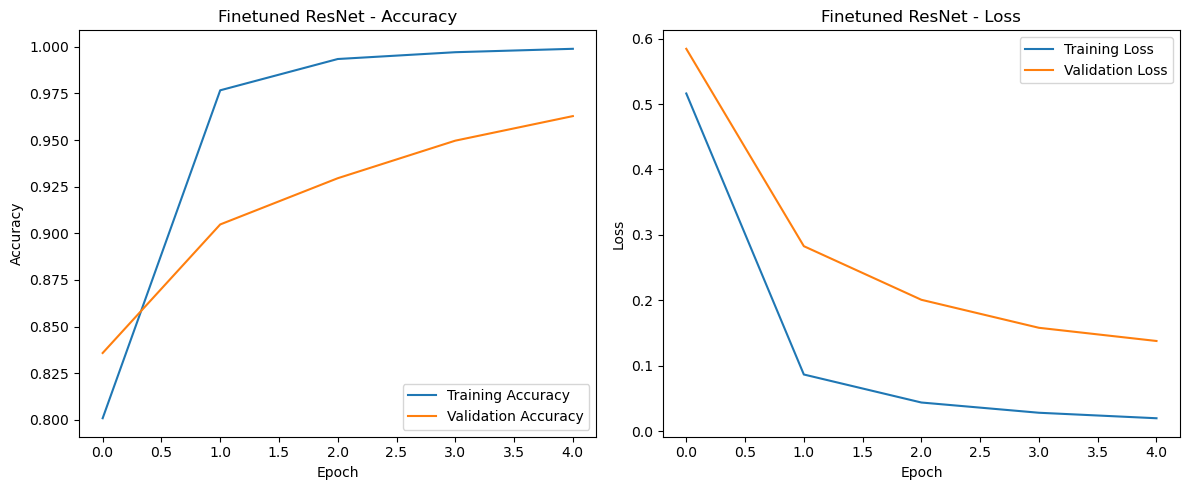

Finetuned ResNet50 Test Accuracy: 96.28%


In [35]:
# Plot training curves for fine-tuned ResNet50
plot_training(history_finetune, 'Finetuned ResNet')

# Evaluate fine-tuned ResNet50 on test data
finetune_test_loss, finetune_test_acc = resnet_model.evaluate(test_ds, verbose=0)
print(f"Finetuned ResNet50 Test Accuracy: {finetune_test_acc*100:.2f}%")

Training was much faster with pretrained features (10 epochs), as compared to fine-tuning (5 epochs). However, by the second fine-tuning epoch model accuracy had already slightly exceeded the base ResNet model, and by the end of the 5th epoch we had exceeded the prior accuracy. Furthermore, since loss continued to drop from epoch 4 to epoch 5 (0.15 to 0.14), that indicates that we potentially could have trained the fine tune model even further--though with a test accuracy of 96% in epoch 5, it is also possible the data at its current size might have been nearing the limits of its image differentiability.

## 4. Additional Architectures

*Implement three additional models of your choice.*

*Use consistent data splits and preprocessing across all models to ensure fair comparison.*

In [38]:
# Define preprocessing for Improved CNN and AlexNet.

def preprocess_tf(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [39]:
#Model 1:
# Improved CNN with more convolutional layers, increased dropout rate, and increased number of dense layers
  # Through this model we can see whether increasing the depth of the model can improve our accuracy measures

def improved_cnn(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    return model

improved_model = improved_cnn(input_shape=(224, 224, 3), num_classes=3)
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
improved_model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,379 (25.99 MB)

 Trainable params: 6,812,419 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [40]:
#Furthermore, this model will employ a longer training period--using 10 epochs
improved_history = improved_model.fit(train_ds, epochs=10, validation_data=(test_ds))
improved_test_loss, improved_test_acc = improved_model.evaluate(test_ds)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.6141 - loss: 22.4603 - val_accuracy: 0.3338 - val_loss: 28.4353
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 394ms/step - accuracy: 0.6866 - loss: 26.1276 - val_accuracy: 0.3331 - val_loss: 30.8176
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 30s 352ms/step - accuracy: 0.6952 - loss: 34.3526 - val_accuracy: 0.3331 - val_loss: 289.8344
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 363ms/step - accuracy: 0.7362 - loss: 34.4254 - val_accuracy: 0.3331 - val_loss: 300.9718
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 358ms/step - accuracy: 0.7618 - loss: 28.6019 - val_accuracy: 0.3331 - val_loss: 231.0389
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.8011 - loss: 21.7279 - val_accuracy: 0.3331 - val_loss: 166.1335
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 32s 371ms/step - accuracy: 0.7854 - loss: 20.1342 - val_accuracy: 0.4508 - val_loss: 55.5544
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 359ms/step - accuracy: 0.8215 - loss:

In [41]:
#Model 2:
# AlexNet Model

alexnet_model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(96, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Second Convolutional Layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Third Convolutional Layer
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

    # Fourth Convolutional Layer
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

    # Fifth Convolutional Layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),

    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer 1
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),  # Dropout Layer

    # Fully Connected Layer 2
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),  # Dropout Layer

    # Output Layer
    layers.Dense(3, activation='softmax')
])

alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
alexnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 256)  │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,169,411 (80.75 MB)

 Trainable params: 21,168,707 (80.75 MB)

 Non-trainable params: 704 (2.75 KB)

In [42]:
alexnet_history = alexnet_model.fit(train_ds, epochs=10, validation_data=(test_ds))
alexnet_test_loss, alexnet_test_acc = alexnet_model.evaluate(test_ds)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3908 - loss: 1.2197 - val_accuracy: 0.3331 - val_loss: 1.2050
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6469 - loss: 0.7367 - val_accuracy: 0.3331 - val_loss: 1.2170
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6729 - loss: 0.6943 - val_accuracy: 0.3331 - val_loss: 1.3854
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.6693 - loss: 0.6846 - val_accuracy: 0.3331 - val_loss: 1.5773
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6707 - loss: 0.7504 - val_accuracy: 0.3331 - val_loss: 1.7915
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.6826 - loss: 0.7756 - val_accuracy: 0.5012 - val_loss: 1.1872
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.6633 - loss: 0.9655 - val_accuracy: 0.6274 - val_loss: 0.7961
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 646s 8s/step - accuracy: 0.6613 - loss: 0.9646 - val_accuracy: 0.5864 - v

In [43]:
# Preprocess for Inception V3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

def preprocess_and_resize(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image * 255.0, tf.float32)
    image = inception_preprocess(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [44]:
# Model 3: Inception
# Inception V3 with transfer learning

base_inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)

for layer in base_inception.layers:
    layer.trainable = False

inception_model = Model(inputs=input_tensor, outputs=predictions)
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [45]:
inception_history = inception_model.fit(train_ds, epochs=10, validation_data=test_ds)
inception_test_loss, inception_test_acc = inception_model.evaluate(test_ds)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 30s 291ms/step - accuracy: 0.5769 - loss: 1.0591 - val_accuracy: 0.8025 - val_loss: 0.4688
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.7621 - loss: 0.5917 - val_accuracy: 0.8389 - val_loss: 0.3907
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 0.7972 - loss: 0.5099 - val_accuracy: 0.8327 - val_loss: 0.3720
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - accuracy: 0.8103 - loss: 0.4731 - val_accuracy: 0.8606 - val_loss: 0.3392
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - accuracy: 0.8276 - loss: 0.3998 - val_accuracy: 0.8629 - val_loss: 0.3312
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.8371 - loss: 0.4361 - val_accuracy: 0.8699 - val_loss: 0.3128
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.8355 - loss: 0.3904 - val_accuracy: 0.8683 - val_loss: 0.3132
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 273ms/step - accuracy: 0.8597 - loss: 0.3525 - val_accu

## 5. Performance Comparison

*Evaluate all models on the same test set.*

*Highlight the model that achieved the best test performance.*

*Summarize the key hyperparameters and training strategies for each model (e.g., learning rate, batch size, number of epochs, optimizer).*

*Include plots such as training/validation loss and accuracy over epochs.*

In [47]:
comparison_df = pd.DataFrame({
    'Model': ['Improved CNN', 'AlexNet', 'Inception V3'],
    'Test Accuracy': [improved_test_acc, alexnet_test_acc, inception_test_acc],
    'Epochs': [10, 10, 10],
    'Optimizer': ['Adam', 'Adam', 'Adam(learning_rate=0.0001)'],
    'Batch Size': [32, 32, 32]
})

display(comparison_df)

,Model,Test Accuracy,Epochs,Optimizer,Batch Size
0,Improved CNN,0.708753,10,Adam,32
1,AlexNet,0.717273,10,Adam,32
2,Inception V3,0.872192,10,Adam(learning_rate=0.0001),32


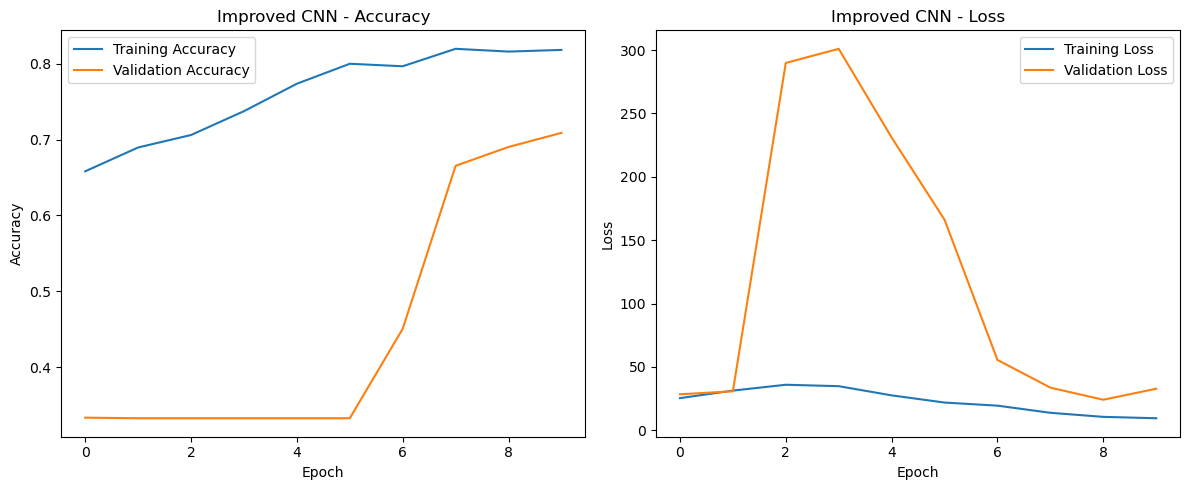

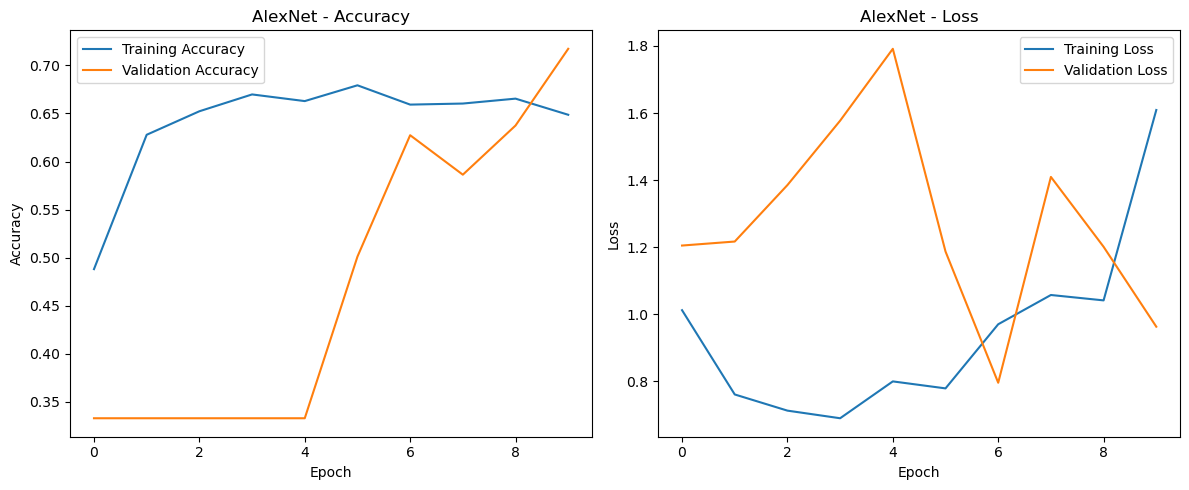

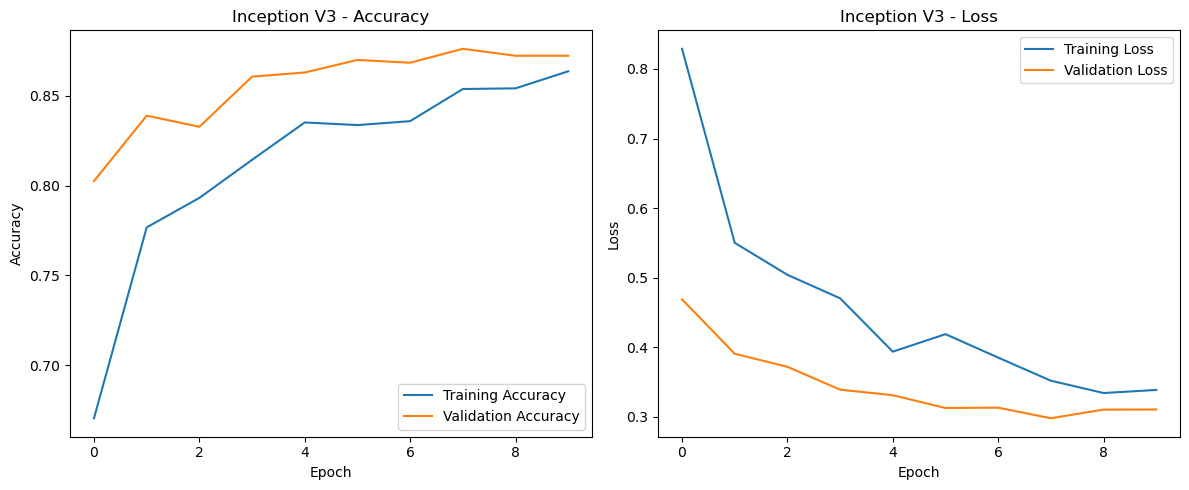

In [48]:
# Training and Validation Performance Plot
plot_training(improved_history, 'Improved CNN')
plot_training(alexnet_history, 'AlexNet')
plot_training(inception_history, 'Inception V3')

## 6. Augmentation

*For at least one model, re-train it using data augmentation techniques.*

*Describe the types of augmentations used (e.g., flipping, cropping, rotation) and how they affected performance.*

We will re-train the Improved CNN model to see it can outperform Inception V3 through data augmentations. We applied the following augmentations:
- Randomly rotating images by up to 10 degrees, either clockwise or counterclockwise
- Randomly shifting images horizontally by up to 5% of the total width
- Randomly shifting images vertically by up to 5% of the total height
- Disabling random horizontal flipping of images, as that could create anatomically incorrect images
- Randomly zooming images in or out by up to 5%

These augmentations will increase the size of the training data through artificial variations. This improve model generalization by forcing it to learn features that are consistent across the transformations.

In [51]:
# Data Augmentation Example
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False, #As flipping the image would be anatomically incorrect.
    fill_mode='nearest'
)

In [52]:
# Redefine the model for augmented data
augmented_model = improved_cnn(input_shape=(192, 192, 3), num_classes=3)
augmented_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
augmented_history = augmented_model.fit(
     datagen.flow(X_train, y_train),
     epochs=10,
     validation_data=(X_test, y_test)
 )

augmented_test_loss, augmented_test_acc = augmented_model.evaluate(X_test, y_test)

/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 529ms/step - accuracy: 0.5573 - loss: 21.4972 - val_accuracy: 0.3331 - val_loss: 69.5498
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - accuracy: 0.6520 - loss: 24.7814 - val_accuracy: 0.3331 - val_loss: 242.8539
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 386ms/step - accuracy: 0.6722 - loss: 30.0041 - val_accuracy: 0.3377 - val_loss: 123.6023
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 377ms/step - accuracy: 0.6723 - loss: 32.2163 - val_accuracy: 0.3354 - val_loss: 134.9595
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step - accuracy: 0.6789 - loss: 28.2994 - val_accuracy: 0.4895 - val_loss: 48.5694
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 747ms/step - accuracy: 0.6651 - loss: 24.8375 - val_accuracy: 0.6251 - val_loss: 29.5197
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 74s 857ms/step - accuracy: 0.6949 - loss: 15.8522 - val_accuracy: 0.6507 - val_loss: 13.4765
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 64s 738ms/step - accuracy: 0.6796 - loss: 

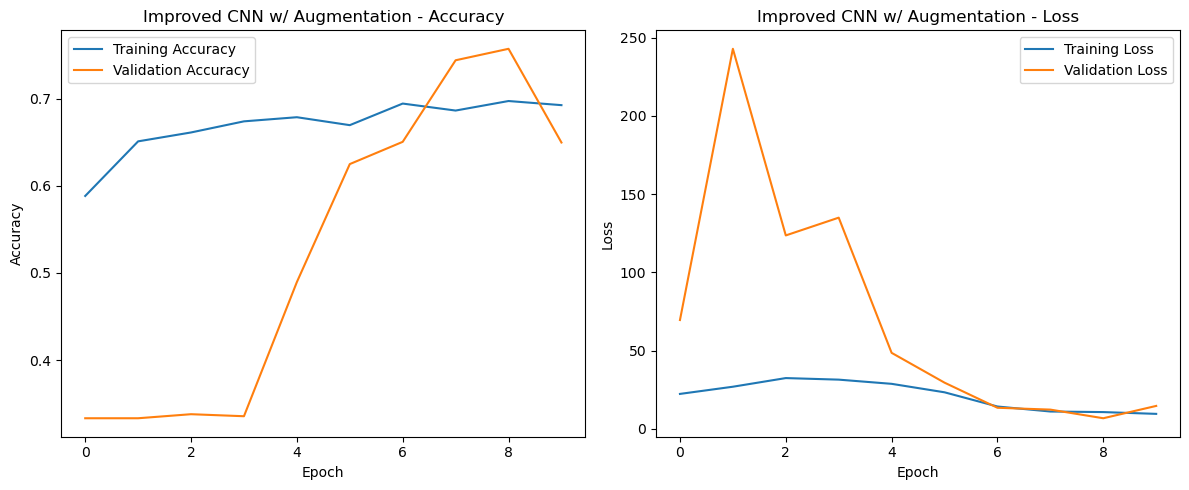

Improved CNN w/ Augmentation Test Accuracy: 64.99%


In [54]:
# Plot training history
plot_training(augmented_history, 'Improved CNN w/ Augmentation')

# Evaluate the model on test data
print(f"Improved CNN w/ Augmentation Test Accuracy: {augmented_test_acc*100:.2f}%")

## 7. Interpretability & Insights

*Reflect on which model performed best and why.*

*Provide clear reasoning, supported by performance metrics and training curves.*

*Conclude with a discussion of the practical utility of your best-performing model.*
*   *Who would benefit from using this model?*
*   *In what types of real-world scenarios would your solution be useful?*

It appears that Inception V3 performed the best out of our 3 models (Improved CNN, AlexNet, and Inception V3), achieving test accuracy of 87%. Even with augmentation, the CNN model had fewer parameters to learn the subtle variations. This is evident in the erratic training curves for both CNN and AlexNet, compared to the smoother curve for Inception V3. Contrasting the additional architectures we created, it was difficult to substantially improve the performance from the baseline model. As predicted, additional epochs did not appear to have a substantial impact on the actual accuracy; though what's more surprising is that adding additional architecture to increase the depth of the model did not overwhelmingly perform the performance. Furthermore, the "Improved CNN model" retrained with augmented images seemed to perform the least well of all of them. Potentially because the model we proposed is not "deep" enough, or have the appropriate regularization technique to learn the features that generalize well across the augmented data.

Out of all the models, ResNet50 with fine-tuning performed the best. Through residual learning and fine-tuning, the model was able to adapat its pre-trained weights to medical images. This may be the most important results as it shows the power that utilizing a powerful pre-trained model, even in a new context, can have on developing an image classifier in a novel context. Fine-tuning only served to improve this performance and to an impressive degree.

From this classification exercise, we can provide insights on how we can apply ML techniques specific to each domain. Further study using this dataset would be able to to aid healthcare professionals in interpretting radiology reports and provide diagnostic support. Without knowing the success rates of average doctors in their capacity to identify positive cases, it's unclear the breadth by which this model may be applied. At the least, however, this may be extremely helpful in hospital systems where the volume of cases may overwhelm doctors capacity to manually review, showing them the most likely images to flag incidents.